In [61]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
import re
from sklearn.metrics import confusion_matrix

In [38]:
#Import dataset

# trimmed2018 = pd.read_csv('cdc2018trimmed.csv') #(84)

# csv2018 = pd.read_csv('CSV2018.csv') # with bettina's function as well, (98 lol)

trimwolabor2018 = pd.read_csv('cdc2018wolabor.csv') #(68)

# trimmed2 = pd.read_csv('cdc2018trimmed2.csv') #(84)

# trimmed2016 = pd.read_csv("CDC2016trimmed.csv") #84.9

# trimwolabor2016 = pd.read_csv('CDC2016wolabor.csv') #67.3

# trimmed2017 = pd.read_csv('CDC2017trimmed.csv') #84.8


In [39]:
#remove unknown AB_NICUs
trimwolabor2018 = trimwolabor2018[trimwolabor2018['AB_NICU'].isin(['Y', 'N'])]

In [3]:
# function to split out holdout test set
def split_sets(dataframe, seed, test_prop=0.1): 
    '''
    - A function that splits specifically a dataframe into a train and test portion
    - Requires multiple assignment: train, test
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    train = dataframe.iloc[trainIdxes,:]
    test  = dataframe.iloc[testIdxes,:]
    
    return train, test

In [40]:
train, test = split_sets(trimwolabor2018, 0, test_prop=0.1)

In [41]:
print(train.shape)
print(test.shape)

(3418273, 54)
(379808, 54)


In [42]:
dsample = train.copy()

In [9]:
#Downsample function, thanks Bettina and Aron!
def downsample_df (df):

    '''
    Remove undefined information on NICU admissions (AB_NICU == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all NICU admissions and matching numbers of randomly selected non-NICU admissions.
    '''

    import pandas as pd
    import numpy as np

    # remove unknown class from df
    df_no_unknown = df[df['AB_NICU'].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = np.where((df_no_unknown['AB_NICU'] == 'Y'), 0, 1)

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

In [43]:
#Downsampled
dsample = downsample_df(dsample)

In [11]:
#LabelEncoding Function. Thanks Ira!
def LabelEncoding(dataframe):
    '''
    Function that takes a dataframe and transforms it with label encoding on all the categorical features.
    '''
    
    import pandas as pd
    
    #create a list using object types since dataframe.dtypes.value_counts() only shows objects and int64
    objlist = list(dataframe.select_dtypes(include=['object']).columns)
    
    #change type then transform column using cat codes
    for col in objlist:
        dataframe[col] = dataframe[col].astype('category')
        dataframe[col] = dataframe[col].cat.codes
    
    return dataframe

In [44]:
#Label Encoded
dsample = LabelEncoding(dsample)
dtest = LabelEncoding(test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
#test train split
X_train = dsample.drop('AB_NICU', axis=1)
y_train = dsample['AB_NICU']
X_test = dtest.drop('AB_NICU', axis=1)
y_test = dtest['AB_NICU']

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(625884, 53)
(379808, 53)
(625884,)
(379808,)


In [47]:
#RANDOM FOREST INITIAL FIT-
randomForest = ensemble.RandomForestClassifier()
randomForest.set_params(random_state=0)
randomForest.fit(X_train, y_train) 
print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The training error is: 0.03227
The test     error is: 0.29307


In [49]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 16),
    'n_estimators': range(10, 50, 10)
}
# GRID SEARCH
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1,)
%time grid_search_forest.fit(X_train, y_train)

CPU times: user 1min 18s, sys: 5.42 s, total: 1min 24s
Wall time: 1h 42min 51s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 16), 'n_estimators': range(10, 50, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [50]:
#Best Params and Score
print(grid_search_forest.best_params_)
grid_search_forest.best_score_

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 40}


0.6483821283177075

In [51]:
# get the training/test errors
print("The training error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_test, y_test)))

The training error is: 0.31683
The test     error is: 0.24384


In [52]:
#list of feature importance
feature_importance = list(zip(dsample.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
[i for (i, j) in feature_sort[0:10]]

[b'PREVIS_REC',
 b'MEDUC',
 b'FEDUC',
 b'WTGAIN_REC',
 b'FAGEREC11',
 b'BMI_R',
 b'MAGER9',
 b'ILLB_R11',
 b'DPLURAL',
 b'MRACEHISP']

In [68]:
#CONFUSION MATRIX
cm = confusion_matrix(y_test, grid_search_forest.best_estimator_.predict(X_test))
cm

array([[267416,  77930],
       [ 14682,  19780]])

In [54]:
#Sorting feature importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
sorted_features

[(b'PREVIS_REC', 0.08846543),
 (b'MEDUC', 0.08048163),
 (b'FEDUC', 0.07469299),
 (b'WTGAIN_REC', 0.06448308),
 (b'FAGEREC11', 0.06318106),
 (b'BMI_R', 0.06069618),
 (b'MAGER9', 0.05806998),
 (b'ILLB_R11', 0.05501394),
 (b'DPLURAL', 0.04313452),
 (b'MRACEHISP', 0.03732498),
 (b'FRACEHISP', 0.03651815),
 (b'PRECARE5', 0.02862685),
 (b'TBO_REC', 0.02744014),
 (b'RESTATUS', 0.02522286),
 (b'WIC', 0.0239719),
 (b'PRIORTERM', 0.02189027),
 (b'MAR_P', 0.02030929),
 (b'LBO_REC', 0.01828794),
 (b'PRIORLIVE', 0.01824108),
 (b'DMAR', 0.01821535),
 (b'RF_GHYPE', 0.01776994),
 (b'CIG3_R', 0.01513421),
 (b'CIG0_R', 0.01190173),
 (b'RF_PPTERM', 0.01020857),
 (b'RF_GDIAB', 0.0083896),
 (b'RF_CESARN', 0.00830886),
 (b'CIG1_R', 0.00709615),
 (b'RF_PHYPE', 0.00686904),
 (b'RF_PDIAB', 0.00647373),
 (b'RF_CESAR', 0.00545726),
 (b'CIG2_R', 0.00528381),
 (b'IP_CHLAM', 0.00498855),
 (b'CA_MNSB', 0.00334545),
 (b'PRIORDEAD', 0.00267367),
 (b'RF_FEDRG', 0.00256447),
 (b'IP_HEPC', 0.00244052),
 (b'RF_ARTEC', 0.0

Text(0.5, 1.0, 'feature importance')

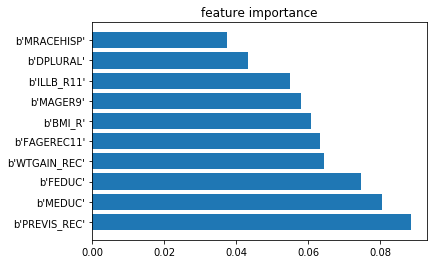

In [55]:
# Plot
features_top10 = sorted_features[:10]
featureNames, featureScores = zip(*list(features_top10))
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.title('feature importance')


In [56]:
#Thanks Drucila!
feature_importance = 100.0 * (randomForest.feature_importances_ / randomForest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 10]
unimportant_features = X_train.columns[feature_importance < 5]

In [57]:
important_features

Index(['MAGER9', 'RESTATUS', 'MRACEHISP', 'MAR_P', 'DMAR', 'MEDUC',
       'FAGEREC11', 'FRACEHISP', 'FEDUC', 'PRIORLIVE', 'PRIORTERM', 'LBO_REC',
       'TBO_REC', 'ILLB_R11', 'PRECARE5', 'PREVIS_REC', 'WIC', 'CIG0_R',
       'CIG3_R', 'BMI_R', 'WTGAIN_REC', 'RF_GHYPE', 'RF_PPTERM', 'DPLURAL'],
      dtype='object')

In [58]:
unimportant_features

Index(['PRIORDEAD', 'RF_EHYPE', 'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'IP_GON',
       'IP_SYPH', 'IP_HEPB', 'IP_HEPC', 'CA_ANEN', 'CA_MNSB', 'CA_CCHD',
       'CA_CDH', 'CA_OMPH', 'CA_GAST', 'CA_LIMB', 'CA_CLEFT', 'CA_CLPAL',
       'CA_DOWN', 'CA_DISOR', 'CA_HYPO'],
      dtype='object')